<hr style="color:#DA01B5">

# Diseño de una Red Bayesiana


<hr style="color:#DA01B5">

Una vez los datos están preparados y guardados, ya se puede crear la red bayesiana. 

In [ ]:
# Cargamos los paquetes necesarios
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from pgmpy.estimators import HillClimbSearch
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination
from sklearn.model_selection import train_test_split


1.0.0


<hr style="color:#DA01B5">

## Día A


<hr style="color:#DA01B5">

<div style="display: flex; align-items: center;">
    <h3 style="margin: 0;"> Observación de los datos </h3>
    <hr style="flex-grow: 1; margin-left: 10px; border: none; border-top: 2px solid #FCBAF1;">
</div>

Se dividen los datos en conjunto de train y de validación. 

\* Se eliminan aquellas filas donde la actividad sea Idle ya que se quiere inferir sobre las actividades y estas filas reducen la precisión del modelo.

In [171]:
letter = 'A'
df = pd.read_csv(f'Data\\data_{letter}.csv', sep=',', index_col=0)

# Eliminamos la ultima columna que no contiene información relevante
df = df.drop(columns=['DAY'])

# Colocamos la columna 'Activity' al principio del DataFrame
cols = ['Activity'] + [col for col in df.columns if col != 'Activity']
df = df[cols]

# Eliminamos las filas que tienen un valor 0 en la columna 'Activity'
df = df[df['Activity'] != 0]
# Dividimos ahora trainval en train y validación
df_train, df_val = train_test_split(df, test_size=0.25, random_state=40, stratify=df['Activity'])

print("\n\033[1;32mDatos de entrenamiento:\033[0m")
print(df_train.shape)
print(df_train.head())
print("\n\033[1;32mDatos de validación:\033[0m")
print(df_val.shape)
print(df_val.head())


Datos de entrenamiento:
(2352, 70)
     Activity  C07  C08  C09  C10  C12  C13  C14  D01  D02  ...  05,01  05,02  \
C04                                                         ...                 
0           5    0    0    0    0    0    0    1    0    0  ...      0      0   
0           2    0    0    0    0    0    0    0    0    0  ...      0      0   
0          22    0    0    0    0    0    0    0    0    0  ...      0      0   
0           2    0    0    0    0    0    0    0    0    0  ...      0      0   
0          17    0    0    0    0    0    0    1    0    0  ...      0      0   

     05,03  05,04  05,05  05,06  05,07  05,08  05,09  05,10  
C04                                                          
0        0      0      0      0      0      0      0      0  
0        0      0      0      1      0      0      0      0  
0        0      0      0      0      0      0      0      0  
0        0      0      0      0      0      0      0      0  
0        0      0      0

<div style="display: flex; align-items: center;">
    <h3 style="margin: 0;"> Modelo </h3>
    <hr style="flex-grow: 1; margin-left: 10px; border: none; border-top: 2px solid #FCBAF1;">
</div>

Se utiliza el método de aprendizaje **HillClimbSearch** para estructurar un modelo gráfico bayesiano a partir de los datos de **df**. El objetivo es encontrar la mejor estructura (red de relaciones entre variables) que explique esos datos. 

Para estimar la estructura del modelo se usa **hc.estimate**. Su criterio de optimización será el **k2** que penaliza la complejidad para evitar el sobreajuste. 

In [ ]:
# Aprender la estructura de la red bayesiana
hc = HillClimbSearch(df_train)
model = hc.estimate(scoring_method="k2", epsilon=1e-13, max_iter=1e6, max_indegree=15)


INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Activity': 'N', 'C07': 'N', 'C08': 'N', 'C09': 'N', 'C10': 'N', 'C12': 'N', 'C13': 'N', 'C14': 'N', 'D01': 'N', 'D02': 'N', 'D03': 'N', 'D04': 'N', 'D07': 'N', 'D09': 'N', 'D10': 'N', 'H01': 'N', 'M01': 'N', 'SM1': 'N', 'SM3': 'N', 'SM4': 'N', '01,01': 'N', '01,02': 'N', '01,03': 'N', '01,04': 'N', '01,05': 'N', '01,06': 'N', '01,07': 'N', '01,08': 'N', '01,09': 'N', '01,10': 'N', '02,01': 'N', '02,02': 'N', '02,03': 'N', '02,04': 'N', '02,05': 'N', '02,06': 'N', '02,07': 'N', '02,08': 'N', '02,09': 'N', '02,10': 'N', '03,01': 'N', '03,02': 'N', '03,03': 'N', '03,04': 'N', '03,05': 'N', '03,06': 'N', '03,07': 'N', '03,08': 'N', '03,09': 'N', '03,10': 'N', '04,01': 'N', '04,02': 'N', '04,03': 'N', '04,04': 'N', '04,05': 'N', '04,06': 'N', '04,07': 'N', '04,08': 'N', '04,09': 'N', '04,10': 'N', '05,01': 'N', '05,02': 'N', '05,03': 'N', '05,04': 'N', '05,05': 'N', '05,06': 'N', '05,0

TypeError: HillClimbSearch.estimate() got an unexpected keyword argument 'white_list'

El modelo aprendido representa dependencias probabilísticas entre sensores y actividad.

Se grafica el modelo para poder visualizarlo.

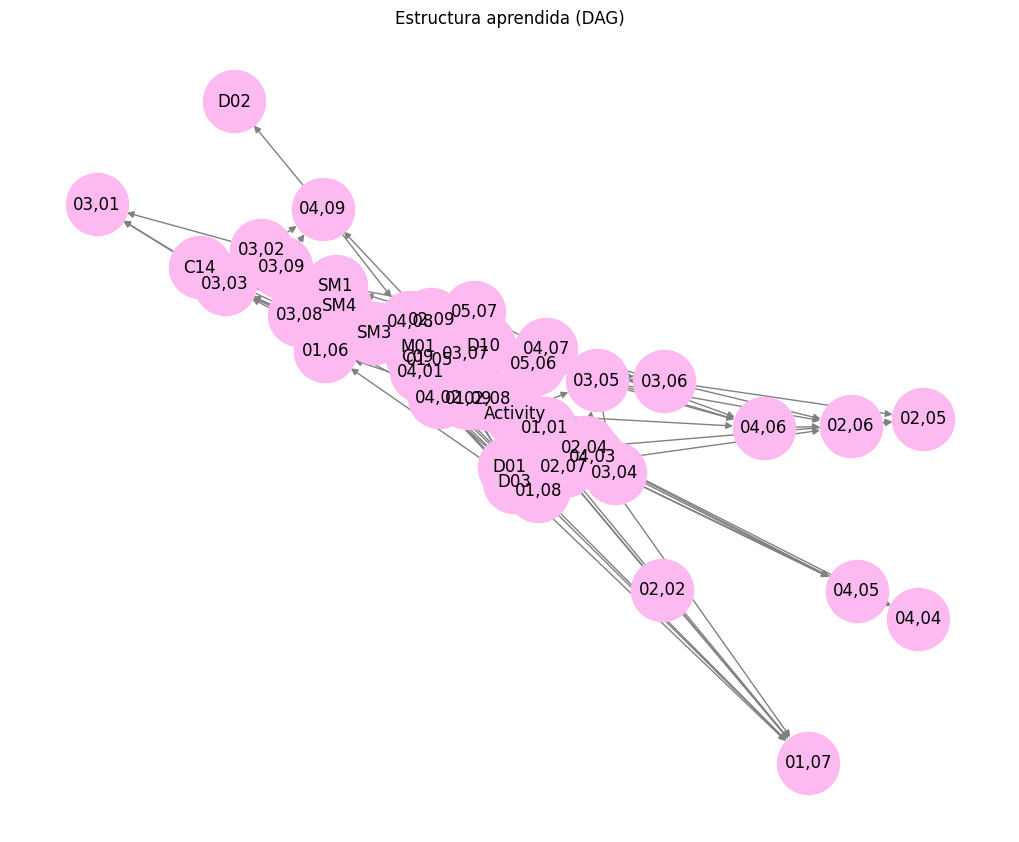

In [173]:
G = nx.DiGraph(model.edges())

plt.figure(figsize=(10, 8))
nx.draw(G, with_labels=True, node_color='#FCBAF1', edge_color='gray', node_size=2000, font_size=12)
plt.title("Estructura aprendida (DAG)")
plt.show()

*model.edges()* devuelve las relaciones dirigidas (aristas) que el HillClimbSearch encontró y *DiscreteBayesianNetwork* crea un objeto red bayesiana con esa estructura, pero aún sin los parámetros (probabilidades).

In [174]:
# Aprender parámetros
bn = DiscreteBayesianNetwork(model.edges())

<div style="display: flex; align-items: center;">
    <h3 style="margin: 0;"> Entrenamiento </h3>
    <hr style="flex-grow: 1; margin-left: 10px; border: none; border-top: 2px solid #FCBAF1;">
</div>

Ajusta los parámetros de la red bayesiana usando los datos del DataFrame **df**.

Usa el método de estimación *Máxima Verosimilitud (MLE)* para calcular las probabilidades condicionadas de cada nodo dados sus padres en la red.

In [175]:
bn.fit(df_train, estimator=MaximumLikelihoodEstimator)
infer = VariableElimination(bn)

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Activity': 'N', 'C07': 'N', 'C08': 'N', 'C09': 'N', 'C10': 'N', 'C12': 'N', 'C13': 'N', 'C14': 'N', 'D01': 'N', 'D02': 'N', 'D03': 'N', 'D04': 'N', 'D07': 'N', 'D09': 'N', 'D10': 'N', 'H01': 'N', 'M01': 'N', 'SM1': 'N', 'SM3': 'N', 'SM4': 'N', '01,01': 'N', '01,02': 'N', '01,03': 'N', '01,04': 'N', '01,05': 'N', '01,06': 'N', '01,07': 'N', '01,08': 'N', '01,09': 'N', '01,10': 'N', '02,01': 'N', '02,02': 'N', '02,03': 'N', '02,04': 'N', '02,05': 'N', '02,06': 'N', '02,07': 'N', '02,08': 'N', '02,09': 'N', '02,10': 'N', '03,01': 'N', '03,02': 'N', '03,03': 'N', '03,04': 'N', '03,05': 'N', '03,06': 'N', '03,07': 'N', '03,08': 'N', '03,09': 'N', '03,10': 'N', '04,01': 'N', '04,02': 'N', '04,03': 'N', '04,04': 'N', '04,05': 'N', '04,06': 'N', '04,07': 'N', '04,08': 'N', '04,09': 'N', '04,10': 'N', '05,01': 'N', '05,02': 'N', '05,03': 'N', '05,04': 'N', '05,05': 'N', '05,06': 'N', '05,0

**TABLAS DE PROBABILIDAD CONDICIONADA**

In [176]:
# Mostrar CPTs
for cpd in bn.get_cpds():
    print(f"\nCPD de la variable: {cpd.variable}")
    print(cpd)


CPD de la variable: Activity
+--------------+-----+----------+----------+----------+
| 01,01        | ... | 01,01(1) | 01,01(1) | 01,01(1) |
+--------------+-----+----------+----------+----------+
| 01,05        | ... | 01,05(1) | 01,05(1) | 01,05(1) |
+--------------+-----+----------+----------+----------+
| 01,09        | ... | 01,09(1) | 01,09(1) | 01,09(1) |
+--------------+-----+----------+----------+----------+
| 02,02        | ... | 02,02(1) | 02,02(1) | 02,02(1) |
+--------------+-----+----------+----------+----------+
| 02,04        | ... | 02,04(1) | 02,04(1) | 02,04(1) |
+--------------+-----+----------+----------+----------+
| 02,07        | ... | 02,07(1) | 02,07(1) | 02,07(1) |
+--------------+-----+----------+----------+----------+
| 03,07        | ... | 03,07(1) | 03,07(1) | 03,07(1) |
+--------------+-----+----------+----------+----------+
| 04,01        | ... | 04,01(1) | 04,01(1) | 04,01(1) |
+--------------+-----+----------+----------+----------+
| 04,02        | .

<div style="display: flex; align-items: center;">
    <h3 style="margin: 0;"> Evaluación </h3>
    <hr style="flex-grow: 1; margin-left: 10px; border: none; border-top: 2px solid #FCBAF1;">
</div>

In [177]:
model_vars = list(bn.nodes())  # Variables que el modelo sí conoce
model_vars.remove('Activity')  # Queremos predecir esta
print(model_vars)
correct = 0

for _, row in df_val.iterrows():
    # Filtrar solo columnas que están en el modelo
    evidence = row[model_vars].to_dict()
    prediction = infer.map_query(['Activity'], evidence=evidence)
    if prediction['Activity'] == row['Activity']:
        correct += 1

accuracy = correct / len(df_val)


['04,09', '03,02', 'SM1', '04,04', '04,05', '03,04', '03,05', '03,09', '04,08', '03,03', 'SM4', 'C14', '01,06', 'D10', '04,06', '04,07', '01,07', 'C09', '03,01', 'D01', 'D03', 'SM3', 'M01', '05,07', '01,01', '01,05', '01,08', '01,09', '02,09', '02,07', '02,02', '02,04', '02,05', '03,07', '02,06', '02,08', '03,06', '03,08', '04,01', '04,02', '04,03', 'D02', '05,06']


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
c:\Users\sheil\anaconda3\envs\TFG\Lib\site-packages\pgmpy\factors\discrete\DiscreteFactor.py:489: RuntimeWarning: invalid value encountered in divide
  phi.values = phi.values / (phi.values.sum())
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?

In [178]:
print(f"Accuracy en validación: {accuracy:.2%}")

Accuracy en validación: 74.90%
